# Dimension Interval

An index keeping two coords in sync. One continuous, and one a set of intervals over the same space as the continuous coords.

**TODO**

Multiple Intervals can potentially span the same continuous dimension. Since we can't put multiple indexes on the same coordinate we can't just stack many DimensionInterval Indexes. We will need to design something that can handle many intervals as one index.

In [16]:
# %xmode minimal
import numpy as np  # noqa: F401
import xarray as xr  # noqa: F401

%load_ext autoreload
%autoreload 2
from linked_indices.interval_index import DimensionInterval
from linked_indices.util import interval_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple case - continuous and intervals - no other coords

The simplest case to consider is where we have two coordinates. `time` and `intervals` where `intervals` represents `intervals` over our continuous dimension (`time`)

In [2]:
ds = interval_dataset(interval_dim="intervals")
ds = (
    ds.drop_indexes(["time", "intervals"])
    .set_xindex(["time", "intervals"], DimensionInterval)
    .drop_vars("word")
)
ds

<xarray.Dataset> Size: 248kB
Dimensions:    (C: 10, time: 1000, rgb: 3, intervals: 4)
Coordinates:
  * time       (time) int64 8kB 0 5 10 15 20 25 ... 4975 4980 4985 4990 4995
  * intervals  (intervals) interval[int64, left] 64B [0, 1000) ... [3500, 4995)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 240kB 1.0 0.0 -0.0 ... 0.3295 0.9983 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

### `sel`


In [3]:
display(ds.sel(time=10))
display(ds.sel(time=slice(10, 1500)))


display(ds.sel(intervals=500))

# below currently raises NotImplemented
# display(ds.sel(intervals=slice(500,1500)))

<xarray.Dataset> Size: 264B
Dimensions:    (C: 10, rgb: 3, time: 1, intervals: 1)
Coordinates:
  * time       (time) int64 8B 10
  * intervals  (intervals) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, rgb) float64 240B 1.0 0.0 -0.0 1.0 0.0 ... -0.0 1.0 0.0 -0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

<xarray.Dataset> Size: 74kB
Dimensions:    (C: 10, time: 299, rgb: 3, intervals: 2)
Coordinates:
  * time       (time) int64 2kB 10 15 20 25 30 35 ... 1480 1485 1490 1495 1500
  * intervals  (intervals) interval[int64, left] 32B [0, 1000) [1000, 2500)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 72kB 1.0 0.0 -0.0 1.0 ... 1.0 0.2806 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

<xarray.Dataset> Size: 50kB
Dimensions:    (C: 10, time: 201, rgb: 3, intervals: 1)
Coordinates:
  * time       (time) int64 2kB 0 5 10 15 20 25 30 ... 975 980 985 990 995 1000
  * intervals  (intervals) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 48kB 1.0 0.0 -0.0 1.0 ... 1.0 0.1664 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

### `isel`
Also works with isel


In [4]:
display(ds.isel(time=3))
display(ds.isel(time=slice(3, 5)))

display(ds.isel(intervals=3))
# below is legitimately broken
# display(ds.isel(intervals=slice(0,2)))

<xarray.Dataset> Size: 264B
Dimensions:    (C: 10, rgb: 3, time: 1, intervals: 1)
Coordinates:
  * time       (time) int64 8B 15
  * intervals  (intervals) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, rgb) float64 240B 1.0 0.0 -0.0 1.0 0.0 ... -0.0 1.0 0.0 -0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

<xarray.Dataset> Size: 512B
Dimensions:    (C: 10, time: 2, rgb: 3, intervals: 1)
Coordinates:
  * time       (time) int64 16B 15 20
  * intervals  (intervals) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 480B 1.0 0.0 -0.0 1.0 ... -0.0 1.0 0.0 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

<xarray.Dataset> Size: 242kB
Dimensions:    (C: 10, time: 300, rgb: 3, intervals: 1)
Coordinates:
  * time       (time) int64 2kB 3500 3505 3510 3515 3520 ... 4980 4985 4990 4995
  * intervals  (intervals) interval[int64, left] 16B [3500, 4995)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 240kB 1.0 0.0 -0.0 ... 0.3295 0.9983 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

## More Complex - Named Intervals

A more complex case is when we have three coords. `time`, `intervals`, `words` (or other name) where the former two are the same as the previous example, and `words` is defined over the same space as `intervals` and essentially provides a label coord for the `intervals` axis.


Here is a schematic of that and what you might expect if did `ds.sel(word='red')`
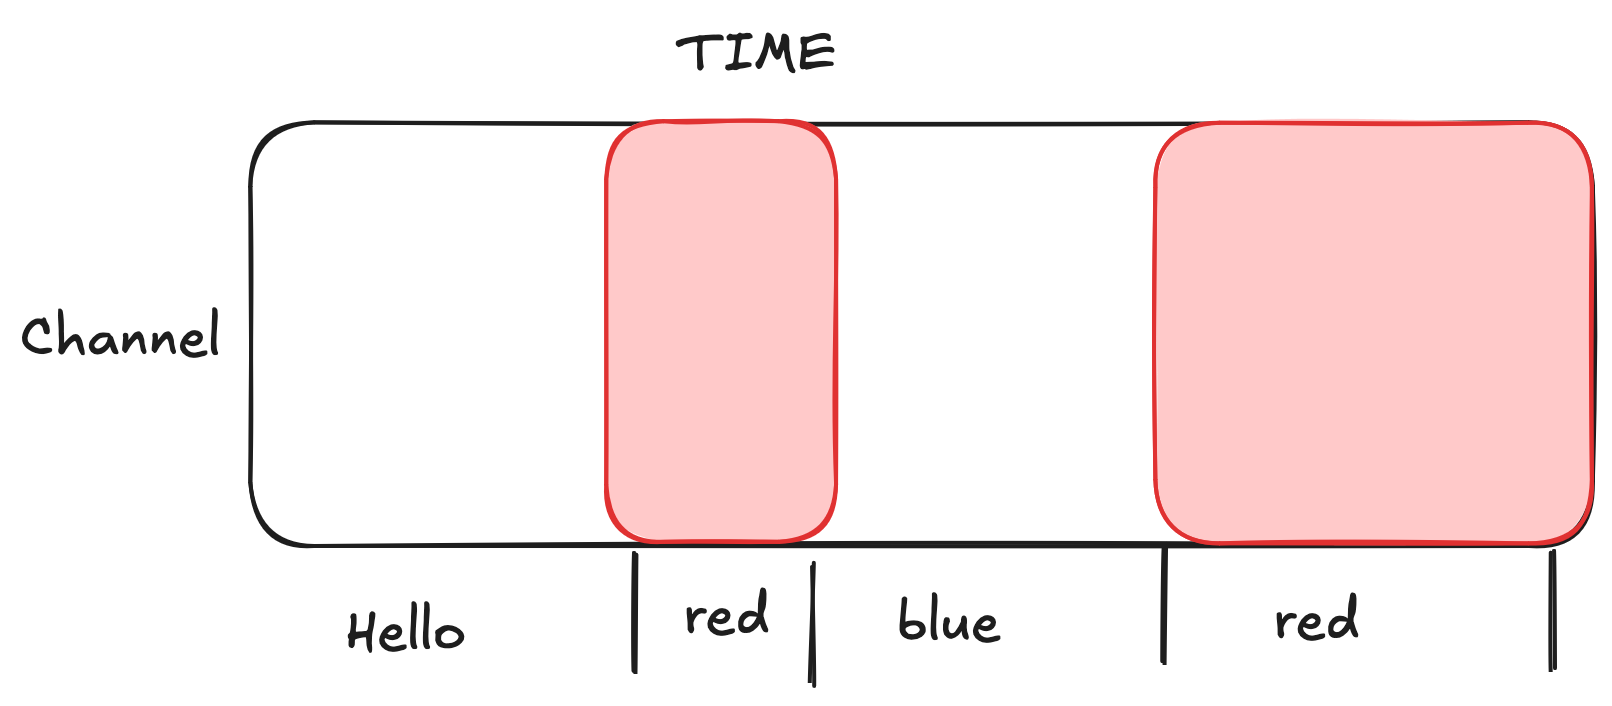


A crucial requirement is to be able to select based on `word`. A simple approach to this is to make a custom index that knows how to keep `word` and `intervals` in sync. However, that adds complexity and makes this less general and reusable by other use cases. Instead we can swap the dimensions a bit. Instead of having `intervals` have `dim=intervals` we set `word` as the dimension coord.

This allows you to `sel` or `isel` on `word` which is the most meaningful space for these users to be selecting over. If you don't make `word` a dimension of the dataset then you cannot `isel` because `isel` only operates on dimensions of the dataset, while `sel` operates on any coord.


This seems to mostly work, but runs into a bug in xarray - see below

In [5]:
ds = interval_dataset(interval_dim="word")
ds = ds.drop_indexes(["time"]).set_xindex(
    ["time", "intervals"],
    DimensionInterval,
    # ).set_xindex('word', pd.CategoricalIndex) # breaks - should figure out how to do
)
ds

<xarray.Dataset> Size: 248kB
Dimensions:    (C: 10, time: 1000, rgb: 3, word: 4)
Coordinates:
  * time       (time) int64 8kB 0 5 10 15 20 25 ... 4975 4980 4985 4990 4995
  * word       (word) <U5 80B 'green' 'red' 'blue' 'red'
  * intervals  (word) interval[int64, left] 64B [0, 1000) ... [3500, 4995)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 240kB 1.0 0.0 -0.0 ... 0.3295 0.9983 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

In [6]:
# works!
ds.sel(word="green")

<xarray.Dataset> Size: 242kB
Dimensions:    (C: 10, time: 201, rgb: 3, word: 1)
Coordinates:
  * time       (time) int64 2kB 0 5 10 15 20 25 30 ... 975 980 985 990 995 1000
    word       <U5 20B 'green'
  * intervals  (word) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 240kB 1.0 0.0 -0.0 ... 0.3295 0.9983 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

In [15]:
# doesn't break, but doesn't actually do any slicing
ds.sel(intervals=500)
# ds.isel(intervals=2)

<xarray.Dataset> Size: 248kB
Dimensions:    (C: 10, time: 1000, rgb: 3, word: 4)
Coordinates:
  * time       (time) int64 8kB 0 5 10 15 20 25 ... 4975 4980 4985 4990 4995
  * word       (word) <U5 80B 'green' 'red' 'blue' 'red'
  * intervals  (word) interval[int64, left] 64B [0, 1000) ... [3500, 4995)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 240kB 1.0 0.0 -0.0 ... 0.3295 0.9983 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

### Limitation

I'm struggling to get `sel/isel` to work in this case when I select based on either `intervals` or `word`. Seemingly because our indexer isn't able to convey that `word` also needs to be sliced at the same time as `intervals`.

For example 

`ds.isel(time=5)`

gives

`ValueError: conflicting sizes for dimension 'word': length 1 on 'intervals' and length 4 on {'word': 'word', 'time': 'time'}`

but we can fake it and everything works fine if we:

`ds.isel(time=5, word=0)`


Similarly

`ds.sel(time=5)` 

gives

`ValueError: dimension 'word' already exists as a scalar variable`


and

`ds.sel(time=slice(1,20))`

`ValueError: conflicting sizes for dimension 'word': length 1 on 'intervals' and length 4 on {'word': 'word', 'time': 'time'}`

In [8]:
ds.isel(time=5)

ValueError: conflicting sizes for dimension 'word': length 1 on 'intervals' and length 4 on {'word': 'word', 'time': 'time'}

<xarray.Dataset> Size: 344B
Dimensions:    (C: 10, rgb: 3, word: 1, time: 1)
Coordinates:
  * word       (word) <U5 80B 'green' 'red' 'blue' 'red'
  * time       (time) int64 8B 25
  * intervals  (word) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, rgb) float64 240B 1.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

In [9]:
ds.isel(time=5, word=0)

<xarray.Dataset> Size: 332B
Dimensions:    (C: 10, rgb: 3, time: 1, word: 4)
Coordinates:
  * time       (time) int64 8B 25
    word       <U5 20B 'green'
  * intervals  (word) interval[int64, left] 64B [0, 1000) ... [3500, 4995)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, rgb) float64 240B 1.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

In [10]:
ds.sel(time=slice(1, 20))

ValueError: conflicting sizes for dimension 'word': length 1 on 'intervals' and length 4 on {'word': 'word', 'time': 'time'}

<xarray.Dataset> Size: 1kB
Dimensions:    (C: 10, time: 4, rgb: 3, word: 1)
Coordinates:
  * time       (time) int64 32B 5 10 15 20
  * word       (word) <U5 80B 'green' 'red' 'blue' 'red'
  * intervals  (word) interval[int64, left] 16B [0, 1000)
Dimensions without coordinates: C, rgb
Data variables:
    data       (C, time, rgb) float64 960B 1.0 0.0 -0.0 1.0 ... -0.0 1.0 0.0 0.0
Indexes:
  ┌ time       DimensionInterval
  └ intervals

In [11]:
ds.sel(time=5)

ValueError: dimension 'word' already exists as a scalar variable